# Backend

In [2]:
import numpy as np
from itertools import product
from collections import OrderedDict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import math

In [3]:
significant_figures = 4
_float_tolerance = 5 * (10 ** -(significant_figures +1))

def _do_float_division_with_tolerance(divisor, dividend,):
    if _do_float_eq_with_tolerance(divisor, dividend):
        return int(1)
    
    quotient = np.true_divide(divisor, dividend)
    return quotient

def _do_float_subtraction_with_tolerance(minuend, subtrahend,):
    difference = np.subtract(minuend, subtrahend)

    if _do_float_le_with_tolerance(difference + _float_tolerance, int(difference)) and _do_float_ge_with_tolerance(difference - _float_tolerance, int(difference)):
        return int(difference)

    return difference

vectorized_float_division_with_tolerance = np.vectorize(_do_float_division_with_tolerance)
vectorized_float_subtraction_with_tolerance = np.vectorize(_do_float_subtraction_with_tolerance)

def _do_float_eq_with_tolerance(given, to_compare, sig_figs=significant_figures):
    tolerance = 5 * (10 ** -(significant_figures +1))
    return round(given - tolerance, sig_figs) <= to_compare and round(given + tolerance, sig_figs) >= to_compare

def _do_float_gt_with_tolerance(given, to_compare, sig_figs=significant_figures):
    tolerance = 5 * (10 ** -(significant_figures +1))
    return round(given - tolerance, sig_figs) > to_compare and round(given + tolerance, sig_figs) > to_compare

def _do_float_lt_with_tolerance(given, to_compare, sig_figs=significant_figures):
    tolerance = 5 * (10 ** -(significant_figures +1))
    return round(given - tolerance, sig_figs) < to_compare and round(given + tolerance, sig_figs) < to_compare

def _do_float_ge_with_tolerance(given, to_compare, sig_figs=significant_figures):
    return _do_float_gt_with_tolerance(given, to_compare, sig_figs) or _do_float_eq_with_tolerance(given, to_compare, sig_figs)

def _do_float_le_with_tolerance(given, to_compare, sig_figs=significant_figures):
    return _do_float_lt_with_tolerance(given, to_compare, sig_figs) or _do_float_eq_with_tolerance(given, to_compare, sig_figs)

vectorized_float_eq_with_tolerance = np.vectorize(_do_float_eq_with_tolerance)
vectorized_float_gt_with_tolerance = np.vectorize(_do_float_gt_with_tolerance)
vectorized_float_lt_with_tolerance = np.vectorize(_do_float_lt_with_tolerance)
vectorized_float_ge_with_tolerance = np.vectorize(_do_float_ge_with_tolerance)
vectorized_float_le_with_tolerance = np.vectorize(_do_float_le_with_tolerance)

In [4]:
M=1

def get_curvature_factor(r_coordinate):

    if r_coordinate == 0:
        return np.inf

    schwarzschild_radius = 2*M
    r_coordinate_scaled_by_M = np.multiply(r_coordinate, M)

    quotient = vectorized_float_division_with_tolerance(divisor=schwarzschild_radius, dividend=r_coordinate_scaled_by_M)
    difference = vectorized_float_subtraction_with_tolerance(minuend=np.ones(np.shape(r_coordinate)), subtrahend=quotient)

    if difference > 0:
        return np.sqrt(difference)
    else:
        return -np.sqrt(np.abs(difference))

def get_energy_per_unit_mass_at_shell(r_coordinate)->float:
    return _do_float_subtraction_with_tolerance(1, _do_float_division_with_tolerance(2*M, r_coordinate))

def V_effective(r_coordinate, angular_momentum_per_unit_mass)->float:
    return _do_float_subtraction_with_tolerance(1, _do_float_division_with_tolerance(2*M, r_coordinate))*_do_float_subtraction_with_tolerance(1, -_do_float_division_with_tolerance(angular_momentum_per_unit_mass, r_coordinate)**2)

def V_effective2(r_coordinate, delta_phi)->float:
    return _do_float_subtraction_with_tolerance(1, _do_float_division_with_tolerance(2*M, r_coordinate))*_do_float_subtraction_with_tolerance(1, - (r_coordinate**2)*delta_phi)

## The Stone

In [5]:
class Stone:
    def __init__(self, starting_coordinate, *, at_rest, energy_per_unit_mass=0, angular_momentum_per_unit_mass=0, dr_direction=-1):
        self.position = [starting_coordinate, ]
        self.dr_direction = dr_direction
        if at_rest:
            self.energy_per_unit_mass = get_energy_per_unit_mass_at_shell(self.position[0].polar.r)
            self.angular_momentum_per_unit_mass = angular_momentum_per_unit_mass
        else:
            self.energy_per_unit_mass = energy_per_unit_mass
            self.angular_momentum_per_unit_mass = angular_momentum_per_unit_mass
    
    def get_path_taken(self):
        t_elapsed = [t for t in np.arange(0, len(self.position))]
        path = self.position.copy()
        path.reverse()
        return path, t_elapsed
    
    def get_path_as_np(self):
        path = self.position.copy()
        path.reverse()
        xs = [ ]
        ys = [ ]
        ts = np.arange(0, len(self.position))
        for step in path:
            xs.append(step.cartesian.x)
            ys.append(step.cartesian.y)
        return np.asarray(xs), np.asarray(ys), ts

## Lattice

### Dimensions dataclass

In [6]:
@dataclass(frozen=True)
class Dimensions:
    left: float
    right: float
    top: float
    bottom: float
    resolution: float

@dataclass(frozen=True)
class PolarDimensions:
    inner_r: float
    outer_r: float
    r_resolution: float
    r_sig_figs: int
    phi_resolution: float
    phi_sig_figs: int

### Coordinate and Coordinate System helper dataclasses

#### Cartesian

In [7]:
@dataclass(frozen=True)
class Cartesian:
    x: int
    y: int

    def __eq__(self, other):
        if isinstance(other, type(self)):
            x_match = vectorized_float_eq_with_tolerance(self.x, other.x)
            y_match = vectorized_float_eq_with_tolerance(self.y, other.y)
            return x_match and y_match
        else:
            return NotImplemented

    def __ge__(self, other):
        if isinstance(other, type(self)):
            x_match = vectorized_float_ge_with_tolerance(self.x, other.x)
            y_match = vectorized_float_ge_with_tolerance(self.y, other.y)
            return x_match and y_match
        else:
            return NotImplemented

    def __le__(self, other):
        if isinstance(other, type(self)):
            x_match = vectorized_float_le_with_tolerance(self.x, other.x)
            y_match = vectorized_float_le_with_tolerance(self.y, other.y)
            return x_match and y_match
        else:
            return NotImplemented

    ## TODO: need to consider case where x == x, y > y
    def __gt__(self, other):
        if isinstance(other, type(self)):
            x_match = vectorized_float_gt_with_tolerance(self.x, other.x)
            y_match = vectorized_float_gt_with_tolerance(self.y, other.y)
            return x_match and y_match
        else:
            return NotImplemented

    def __lt__(self, other):
        if isinstance(other, type(self)):
            x_match = vectorized_float_lt_with_tolerance(self.x, other.x)
            y_match = vectorized_float_lt_with_tolerance(self.y, other.y)
            return x_match and y_match
        else:
            return NotImplemented

#### Polar

In [8]:
@dataclass(frozen=True)
class Polar:
    r: int
    phi: float

    def __eq__(self, other):
        if isinstance(other, type(self)):
            r_match = vectorized_float_eq_with_tolerance(self.r, other.r)
            phi_match = vectorized_float_eq_with_tolerance(self.phi, other.phi)
            return r_match and phi_match
        else:
            return NotImplemented

    def __ge__(self, other):
        if isinstance(other, type(self)):
            r_match = vectorized_float_ge_with_tolerance(self.r, other.r)
            phi_match = vectorized_float_ge_with_tolerance(self.phi, other.phi)
            return r_match and phi_match
        else:
            return NotImplemented

    def __le__(self, other):
        if isinstance(other, type(self)):
            r_match = vectorized_float_le_with_tolerance(self.r, other.r)
            phi_match = vectorized_float_le_with_tolerance(self.phi, other.phi)
            return r_match and phi_match
        else:
            return NotImplemented

    def __gt__(self, other):
        if isinstance(other, type(self)):
            if vectorized_float_eq_with_tolerance(self.r, other.r):
                return vectorized_float_gt_with_tolerance(self.phi, other.phi)

            r_match = vectorized_float_gt_with_tolerance(self.r, other.r)
            phi_match = vectorized_float_gt_with_tolerance(self.phi, other.phi)

            return r_match and phi_match
        else:
            return NotImplemented

    def __lt__(self, other):
        if isinstance(other, type(self)):
            if vectorized_float_eq_with_tolerance(self.r, other.r):
                return vectorized_float_lt_with_tolerance(self.phi, other.phi) 

            r_match = vectorized_float_lt_with_tolerance(self.r, other.r)
            phi_match = vectorized_float_lt_with_tolerance(self.phi, other.phi)
            return r_match and phi_match
        else:
            return NotImplemented

#### Coordinates

In [9]:
class Coordinate:
    def __init__(self, q1: float, q2: float, is_cartesian=True,):
        if is_cartesian:
            self.cartesian = Cartesian(q1, q2)
            self.polar = Coordinate.convert_from_cartesian(self.cartesian)
        else:
            if _do_float_lt_with_tolerance(q2, 0):
                q2 = _do_float_subtraction_with_tolerance(q2, -2*np.pi)
            elif _do_float_ge_with_tolerance(q2, 2*np.pi):
                q2 = _do_float_subtraction_with_tolerance(q2, 2*np.pi)

            self.polar = Polar(q1, round(q2, significant_figures))
            self.cartesian = Coordinate.convert_from_polar(self.polar)
        self.curvature = get_curvature_factor(self.polar.r)
    
    def convert_from_polar(coordinates_to_convert: Polar):
        x_coordinate = np.multiply(coordinates_to_convert.r, np.cos(coordinates_to_convert.phi))
        y_coordinate = np.multiply(coordinates_to_convert.r, np.sin(coordinates_to_convert.phi))

        return Cartesian(x=x_coordinate, y=y_coordinate)

    def convert_from_cartesian(coordinates_to_convert: Cartesian):
        r_coordinate = np.sqrt(np.power(coordinates_to_convert.x , 2) + np.power(coordinates_to_convert.y , 2))

        if r_coordinate == 0:
            return Polar(r=r_coordinate, phi=0)
        
        phi_coordinate = np.arctan2(coordinates_to_convert.y, coordinates_to_convert.x)

        if _do_float_lt_with_tolerance(phi_coordinate, 0):
            phi_coordinate = _do_float_subtraction_with_tolerance(phi_coordinate, -2*np.pi)

        return Polar(r=r_coordinate, phi=phi_coordinate)
    
    def __eq__(self, other):
        if isinstance(other, type(self)):
            return self.cartesian == other.cartesian and self.polar == other.polar
        else:
            return NotImplemented

    def __gt__(self, other):
        if isinstance(other, type(self)):
            return self.cartesian > other.cartesian and self.polar > other.polar
        else:
            return NotImplemented

    def __ge__(self, other):
        if isinstance(other, type(self)):
           return self.cartesian >= other.cartesian and self.polar >= other.polar
        else:
            return NotImplemented

    def __lt__(self, other):
        if isinstance(other, type(self)):
            return self.cartesian < other.cartesian and self.polar < other.polar
        else:
            return NotImplemented

    def __le__(self, other):
        if isinstance(other, type(self)):
           return self.cartesian <= other.cartesian and self.polar <= other.polar
        else:
            return NotImplemented


### The Latticework Class

#### Creation

In [10]:
class Latticework:

    def __init__(self, /, dimensions: Dimensions=None, polar_dimensions: PolarDimensions=None):
        self.mesh = None
        self.cartesian_dimensions = None
        self.polar_dimensions = None

        if not dimensions is  None:
            self.cartesian_dimensions = dimensions
            self._build_cartesian_grid()
        if not polar_dimensions is None:
            self.polar_dimensions = polar_dimensions
            self._build_polar_grid()
    
    def _build_cartesian_grid(self):
        self.vertices = { }

        number_of_x_vertices = int((np.abs(self.cartesian_dimensions.left)+np.abs(self.cartesian_dimensions.right))/self.cartesian_dimensions.resolution) +1
        number_of_y_vertices = int(((np.abs(self.cartesian_dimensions.bottom)+np.abs(self.cartesian_dimensions.top)))/self.cartesian_dimensions.resolution) +1

        for x in np.linspace(start=self.cartesian_dimensions.left, stop=self.cartesian_dimensions.right, num=number_of_x_vertices, endpoint=True):
            for y in np.linspace(start=self.cartesian_dimensions.bottom, stop=self.cartesian_dimensions.top, num=number_of_y_vertices, endpoint=True):
                self.vertices.update({(x, y) : Coordinate(q1=x, q2=y)})
        self._build_meshgrid()

    def _build_polar_grid(self):

        number_of_r_vertices = int((np.abs(self.polar_dimensions.inner_r)+np.abs(self.polar_dimensions.outer_r))/self.polar_dimensions.r_resolution) +1
        number_of_phi_vertices = int((2*np.pi)/self.polar_dimensions.phi_resolution)

        R = np.linspace(start=self.polar_dimensions.inner_r, stop=self.polar_dimensions.outer_r, num=number_of_r_vertices, endpoint=True)
        Phi = np.linspace(start=0, stop=2*np.pi, num=number_of_phi_vertices, endpoint=False)

        R, Phi = np.meshgrid(R, Phi)
        self.mesh = R, Phi
        self.vertices = np.empty(R.shape, dtype=object).T

        it = np.nditer([R, Phi], flags=['multi_index', 'refs_ok'])

        for r, phi in it:
            r, phi = round(r[()], self.polar_dimensions.r_sig_figs), round(phi[()], self.polar_dimensions.phi_sig_figs) #convert 0-Dim arrays to scalars
            iphi, ir = it.multi_index
            self.vertices[ir, iphi] = Coordinate(r, phi, is_cartesian=False)

    def get_curvature_meshgrid(self):

        if self.polar_dimensions is None:
            number_of_X_samples = int((np.abs(self.cartesian_dimensions.left)+np.abs(self.cartesian_dimensions.right))/self.cartesian_dimensions.resolution) +1
            number_of_Y_samples = int((np.abs(self.cartesian_dimensions.bottom)+np.abs(self.cartesian_dimensions.top))/self.cartesian_dimensions.resolution) +1

            X = np.linspace(start=self.cartesian_dimensions.left, stop=self.cartesian_dimensions.right, num=number_of_X_samples, endpoint=True)
            Y = np.linspace(start=self.cartesian_dimensions.bottom, stop=self.cartesian_dimensions.top, num=number_of_Y_samples, endpoint=True)
            Z = np.zeros((len(X), len(Y)))

            for i, (x,y) in enumerate(product(X,Y)):
                if _do_float_gt_with_tolerance(self.vertices[x,y].polar.r, 2*M + self.cartesian_dimensions.resolution, sig_figs=1):
                    Z[np.unravel_index(i, (len(X), len(Y)))] = np.true_divide(1, self.vertices[x,y].curvature)

            z_max_index = np.unravel_index(np.argmax(Z), Z.shape)
            Z = np.where(Z == 0, Z[z_max_index]+1, Z)

            X, Y = np.meshgrid(X, Y)
            
            return (X, Y, Z)
        
        if self.cartesian_dimensions is None:

            R, Phi = self.mesh
            X, Y = R*np.cos(Phi), R*np.sin(Phi)

            Z = np.zeros(X.shape)
            offset = self.polar_dimensions.r_resolution/2 if self.polar_dimensions.r_resolution >= 1 else self.polar_dimensions.r_resolution

            it = np.nditer([X, Y], flags=['multi_index'])
            for x, y, in it:
                ix, iy = it.multi_index
                r = round(math.sqrt(math.pow(x,2) + math.pow(y,2))*M, self.polar_dimensions.r_sig_figs)
                
                if r <= 2.0*M:
                    Z[ix, iy] = 1/get_curvature_factor(2*M+offset/2)
                else:
                    Z[ix, iy] = 1/get_curvature_factor(r)
                
            return (X, Y, Z)

    def get_path_meshgrid(self, stone: Stone)->tuple:
        R, Phi = self.mesh
        X, Y = R*np.cos(Phi), R*np.sin(Phi)

        Z = np.zeros(X.shape)
        offset = self.polar_dimensions.r_resolution/2 if self.polar_dimensions.r_resolution >= 1 else self.polar_dimensions.r_resolution

        r_t = { }
        for t, coord in enumerate(stone.position):
            if coord.polar.r not in r_t.keys():
                r_t.update({coord.polar.r : t})

        it = np.nditer([X, Y], flags=['multi_index'])
        for x, y, in it:
            ix, iy = it.multi_index
            r = round(math.sqrt(math.pow(x,2) + math.pow(y,2))*M, self.polar_dimensions.r_sig_figs)
            
            if r > max(r_t.keys()):
                Z[ix, iy] = 0
            elif r < min(r_t.keys()):
                Z[ix, iy] = len(stone.position) + 10
            else:
                for stone_r, t in r_t.items():
                    if (r == stone_r):
                        Z[ix, iy] = t

            # Z[ix, iy] = 1/get_curvature_factor(r)
            
        return (X, Y, Z)

    def _edge_cost(self, current: Polar, next: Polar, stone: Stone):
        v_eff = V_effective(next.r, stone.angular_momentum_per_unit_mass)
        if math.fabs(v_eff) > stone.energy_per_unit_mass ** 2:
            return np.nan
        
        energy_difference = stone.energy_per_unit_mass**2 - v_eff
        dtau = (next.r - current.r)/math.sqrt(math.fabs(energy_difference))
        if stone.dr_direction > 0:
            dtau *= -1
        sign = _do_float_division_with_tolerance(energy_difference, math.fabs(energy_difference))
        return sign * dtau

    def build_graph(self, stone: Stone)->None:
        self.graph = { }

        it = np.nditer(self.mesh, flags=['multi_index', 'refs_ok'])
        phi_max_index, r_max_index = it.shape

        for r, phi in it:

            #convert 0-Dim arrays to scalars
            r, phi = round(r[()], self.polar_dimensions.r_sig_figs), round(phi[()], self.polar_dimensions.phi_sig_figs) 
            iphi, ir = it.multi_index

            vertex_to_get_neighbors_for = self.vertices[ir, iphi].polar

            # Skip everying inside the horizon
            if _do_float_le_with_tolerance(r, 2*M):
                continue

            self.graph.update({vertex_to_get_neighbors_for : [ ]})

            neighbors = [ ]
            for n_r, n_phi in product(range(ir-1, ir+2), range(iphi-1, iphi+2)):
                if n_r == r_max_index:
                    continue
                if n_phi == phi_max_index: #Wrap around
                    neighbors.append(self.vertices[n_r, n_phi-phi_max_index].polar)
                else:
                    neighbors.append(self.vertices[n_r, n_phi].polar)
            for neighbor in neighbors:
                edge_cost = self._edge_cost(vertex_to_get_neighbors_for, neighbor, stone)
                if not np.isfinite(edge_cost):
                    continue
                angular_cost = 0
                delta_phi_remainder = math.remainder(neighbor.phi - phi, 2*np.pi)
                if delta_phi_remainder == 0:
                    angular_cost = -1*stone.angular_momentum_per_unit_mass
                if stone.angular_momentum_per_unit_mass > 0:
                    if delta_phi_remainder < 0:
                        angular_cost = -2*stone.angular_momentum_per_unit_mass
                else:
                    if delta_phi_remainder > 0:
                        angular_cost = -2*stone.angular_momentum_per_unit_mass

                self.graph[vertex_to_get_neighbors_for].append((neighbor, edge_cost-angular_cost))
            self.graph[vertex_to_get_neighbors_for].sort(key=lambda neighbor_cost_pair: neighbor_cost_pair[1])
    
    def find_path_for_stone(self, stone: Stone):

        total_cost = 0
        while not (stone.position[0].polar.r == stone.position[-1].polar.r and len(stone.position) > 1):
            
            stone_position_polar = stone.position[0].polar
            possible_destinations = np.asarray(self.graph[Polar(round(stone_position_polar.r, self.polar_dimensions.r_sig_figs), round(stone_position_polar.phi, self.polar_dimensions.phi_sig_figs)) ])

            destinations_with_positive_flow = [possible_destinations[:,1] < 0]

            if possible_destinations[tuple(destinations_with_positive_flow)].shape == (0, 2):
                # for neighbor, cost in possible_destinations:
                #     print(f'{neighbor} with cost: {cost}')
                #change direction
                stone.dr_direction *= -1
                self.build_graph(stone)

                print(f'\nReached extrema radius ({stone_position_polar.r}, {stone_position_polar.phi}).\n')

                possible_destinations = np.asarray(self.graph[Polar(round(stone_position_polar.r, self.polar_dimensions.r_sig_figs), round(stone_position_polar.phi, self.polar_dimensions.phi_sig_figs)) ])
                destinations_with_positive_flow = [possible_destinations[:,1] < 0]

            step_taken, cost_of_step = possible_destinations[tuple(destinations_with_positive_flow)][0]
            total_cost -= cost_of_step
            stone.position.insert(0, Coordinate(step_taken.r, step_taken.phi, is_cartesian=False))

            # print(f'Stepped to: {step_taken} with dtau cost of {-cost_of_step}.')
        print(f'\nElapsed proper time of path: {total_cost}')


# Dijkstra's Algorithm

## Pathfinding

In [72]:
initial_stone_Coordinate = Coordinate(19.9, 0, is_cartesian=False)
stone_Astar = Stone(
        initial_stone_Coordinate, 
        at_rest=False,
        energy_per_unit_mass=math.sqrt(V_effective(r_coordinate=20, angular_momentum_per_unit_mass=4)),
        angular_momentum_per_unit_mass=4,
        dr_direction=-1
    )
lattice_dimensions = PolarDimensions(
        inner_r=0,
        outer_r=21,
        r_resolution=0.1,
        r_sig_figs=significant_figures,
        phi_resolution=0.075,
        phi_sig_figs=significant_figures
    )
lattice = Latticework(polar_dimensions=lattice_dimensions)

In [73]:
lattice.build_graph(stone=stone_Astar)

In [74]:
lattice.find_path_for_stone(stone=stone_Astar)


Reached extrema radius (8.3, 2.4981).


Elapsed proper time of path: 351.14509213243747


# Verlet Theoretical Path

In [16]:
class VerletPathfinder:
    def __init__(self, stone: Stone):
        self.stone = stone

    def effective_potential(self):
        return (1 - _do_float_division_with_tolerance((2*M), self.stone.position[0].polar.r))*(1 + math.pow(_do_float_division_with_tolerance(self.stone.angular_momentum_per_unit_mass,  self.stone.position[0].polar.r), 2))

    def V(self, angular_momentum_per_unit_mass, r_coord):
        return (1 - _do_float_division_with_tolerance((2*M), r_coord))*(1 + math.pow(_do_float_division_with_tolerance(angular_momentum_per_unit_mass,  r_coord), 2))

    def dV_dr(self, position: Polar, angular_momentum_per_unit_mass: float)->float:
        numerator = M*math.pow(position.r, 2) + math.pow(angular_momentum_per_unit_mass, 2) * (3 * M - position.r)
        denominator = math.pow(position.r, 4)
        return _do_float_division_with_tolerance(numerator, denominator)

    def dr_doubledot(self, position: Polar, angular_momentum_per_unit_mass: float)->float:
        return - self.dV_dr(position, angular_momentum_per_unit_mass)

    # def dr_dot(stone: Stone)->float:
    #     difference = _do_float_subtraction_with_tolerance(math.pow(stone.energy_per_unit_mass, 2), effective_potential(stone))
    #     return -1*(_do_float_division_with_tolerance(difference, math.fabs(difference)))*math.sqrt(math.fabs(difference))

    def dr_dot(self)->float:
        difference = _do_float_subtraction_with_tolerance(math.pow(self.stone.energy_per_unit_mass, 2), self.effective_potential())
        return -1*(_do_float_division_with_tolerance(difference, math.fabs(difference)))*math.sqrt(math.fabs(difference))

    def calculate_path_using_verlet(self, dtau: float)->None:
        coordinate_after_step = Coordinate(
            q1= round(self.stone.position[0].polar.r, lattice.polar_dimensions.r_sig_figs), 
            q2= round(self.stone.position[0].polar.phi, lattice.polar_dimensions.phi_sig_figs), 
            is_cartesian=False
            )

        has_not_returned_to_initial_coordinates = True 

        current_position = self.stone.position[0].polar
        current_speed = self.dr_dot() 
        current_acceleration = self.dr_doubledot(current_position, self.stone.angular_momentum_per_unit_mass)

        #Verlet Velocity Method https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet 
        while _do_float_gt_with_tolerance(coordinate_after_step.polar.r, (2*M)) and (has_not_returned_to_initial_coordinates or len(self.stone.position) < 1001):

            dphi = (self.stone.angular_momentum_per_unit_mass / math.pow(self.stone.position[0].polar.r, 2)) * dtau

            next_position = Coordinate(
                q1= round(current_position.r + current_speed*dtau + current_acceleration*math.pow(dtau, 2)*0.5, lattice.polar_dimensions.r_sig_figs),
                q2= round(current_position.phi + dphi, lattice.polar_dimensions.phi_sig_figs),
                is_cartesian=False
            )

            next_acceleration = self.dr_doubledot(next_position.polar, self.stone.angular_momentum_per_unit_mass)
            next_speed = current_speed + (current_acceleration + next_acceleration)*(dtau*0.5)

            #Guard against too big of a step:
            if next_position.polar.r <= 2*M:
                print(next_position.polar.r)
                return

            self.stone.position.insert(0, next_position)

            current_position = next_position.polar
            current_speed = next_speed
            current_acceleration = next_acceleration

            if (self.stone.position[0].polar.r == self.stone.position[-1].polar.r):
                has_not_returned_to_initial_coordinates = False
                break
        
        if not has_not_returned_to_initial_coordinates:
            print(f'{has_not_returned_to_initial_coordinates=}')

In [79]:
stone_Verlet = Stone(
        initial_stone_Coordinate, 
        at_rest=False,
        energy_per_unit_mass=math.sqrt(V_effective(r_coordinate=20, angular_momentum_per_unit_mass=4)),
        angular_momentum_per_unit_mass=4,
        dr_direction=-1
    )
verlet_dtau = 0.1
verlet_pathfinder = VerletPathfinder(stone_Verlet)
verlet_pathfinder.calculate_path_using_verlet(verlet_dtau)

has_not_returned_to_initial_coordinates=False


# Visualization

## Mesh

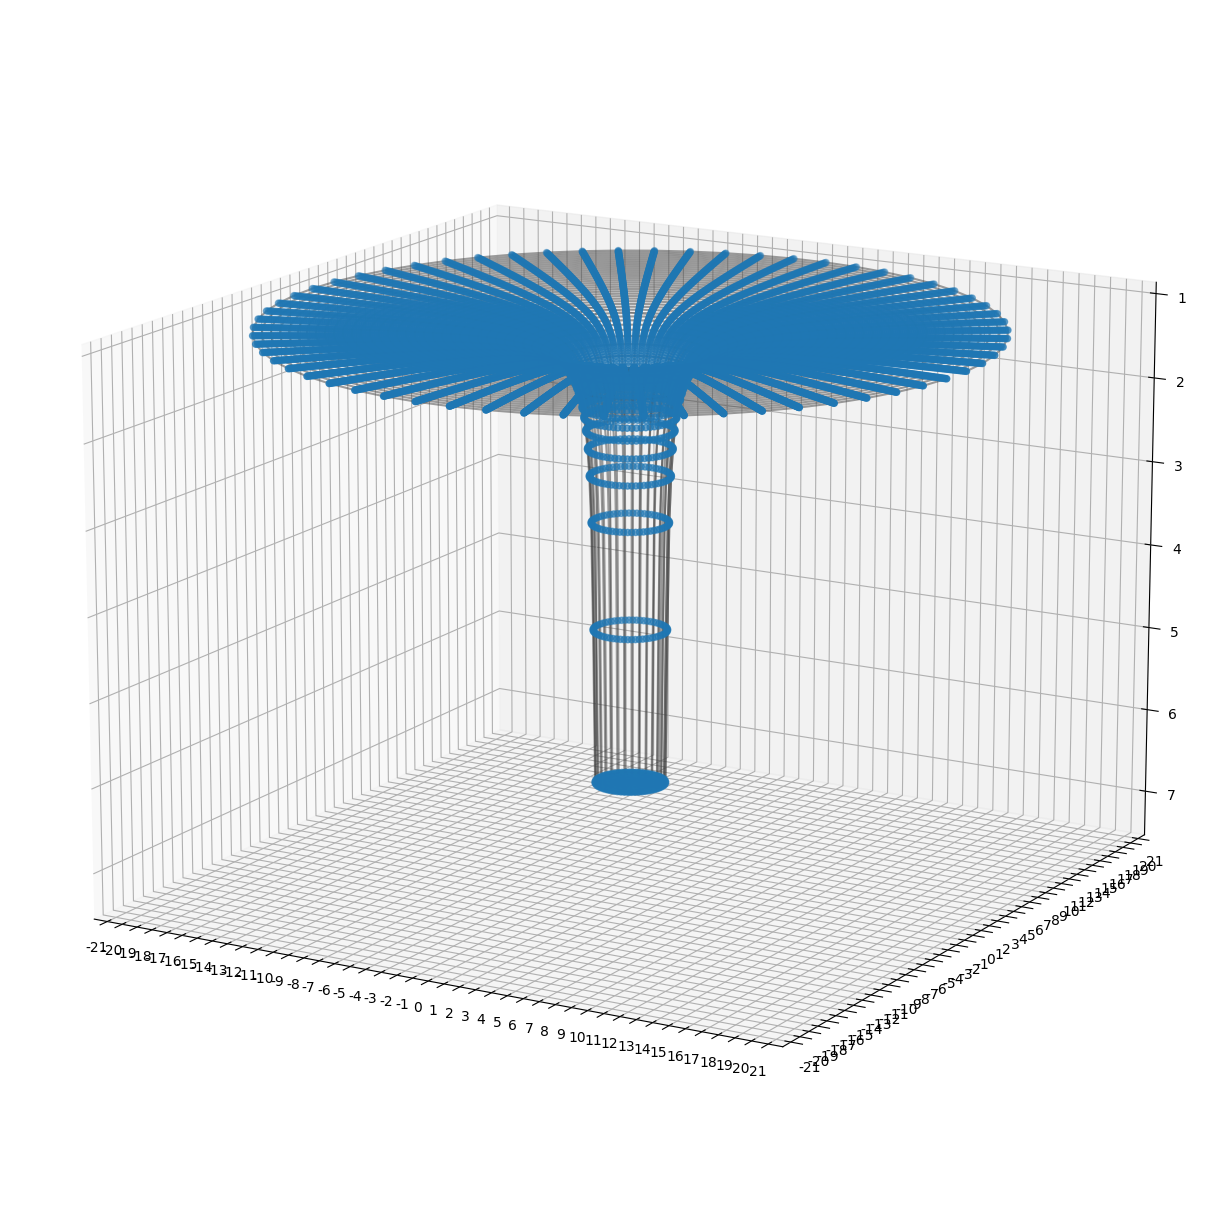

In [ ]:
def draw_layout_3D(lattice, figure_size = (16,16)):

    fig = plt.figure(figsize=figure_size, dpi=100,)
    ax = fig.add_subplot(projection='3d')

    X, Y, Z = lattice.get_curvature_meshgrid()
    colors = [ ]

    it = np.nditer([X, Y], flags=['multi_index'])

    for x, y, in it:
        colors.append((0.25, 0.25, 0.25, 0.5))

    ax.plot_wireframe(X, Y, Z, colors=colors)

    ax.scatter3D(X, Y, Z)

    ax.set_xlim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
    ax.set_xticks([x for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
    ax.set_xticklabels( [f'{int(x)}' for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

    ax.set_ylim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
    ax.set_yticks([y for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
    ax.set_yticklabels( [f'{int(y)}' for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

    z_max_index = np.unravel_index(np.argmax(Z), (Z).shape)

    ax.set_zlim( bottom=Z[z_max_index]+1, top=1,)

    return fig, ax

fig, ax = draw_layout_3D(lattice=lattice)
ax.view_init(15,-60)

## Paths

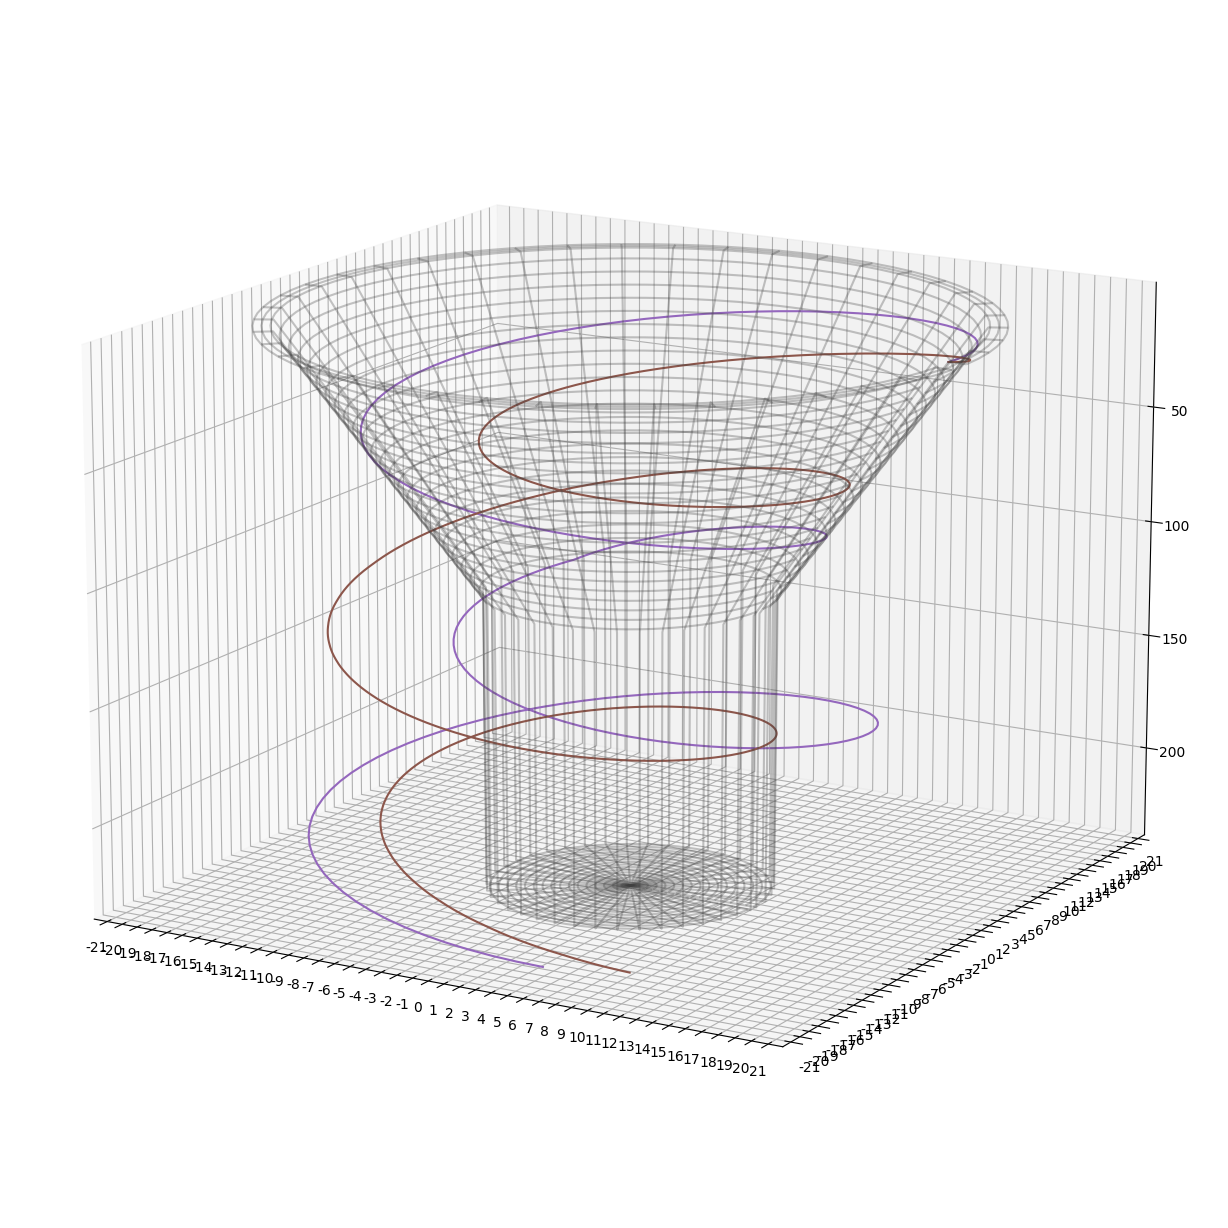

In [80]:
def draw_path_3D(lattice, figure_size = (16,16)):

    fig = plt.figure(figsize=figure_size, dpi=100,)
    ax = fig.add_subplot(projection='3d')

    X, Y, Z = lattice.get_path_meshgrid(stone_Astar)
    colors = [ ]

    it = np.nditer([X, Y], flags=['multi_index'])

    for x, y, in it:
        colors.append((0.25, 0.25, 0.25, 0.3))

    ax.plot_wireframe(X, Y, Z, colors=colors)

    # ax.scatter3D(X, Y, Z)
    stone_X, stone_Y, stone_T = stone_Astar.get_path_as_np()
    astar_elapsed = len(stone_T)
    ax.plot(stone_X, stone_Y, stone_T, c='C4')

    stone_X, stone_Y, stone_T = stone_Verlet.get_path_as_np()
    ax.plot(stone_X, stone_Y, np.multiply(stone_T, astar_elapsed/len(stone_T)), c='C5')

    ax.set_xlim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
    ax.set_xticks([x for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
    ax.set_xticklabels( [f'{int(x)}' for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

    ax.set_ylim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
    ax.set_yticks([y for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
    ax.set_yticklabels( [f'{int(y)}' for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

    z_max_index = np.unravel_index(np.argmax(Z), (Z).shape) 

    if len(stone_Astar.position) > len(stone_Verlet.position)*verlet_dtau:
        ax.set_zlim( bottom=Z[z_max_index]+1, top=1,)
    else:
        ax.set_zlim( bottom=len(stone_Verlet.position)*(astar_elapsed/len(stone_T))+1, top=1,)
    

    return fig, ax
fig, ax = draw_path_3D(lattice=lattice)
ax.view_init(15,-60)

## Animation

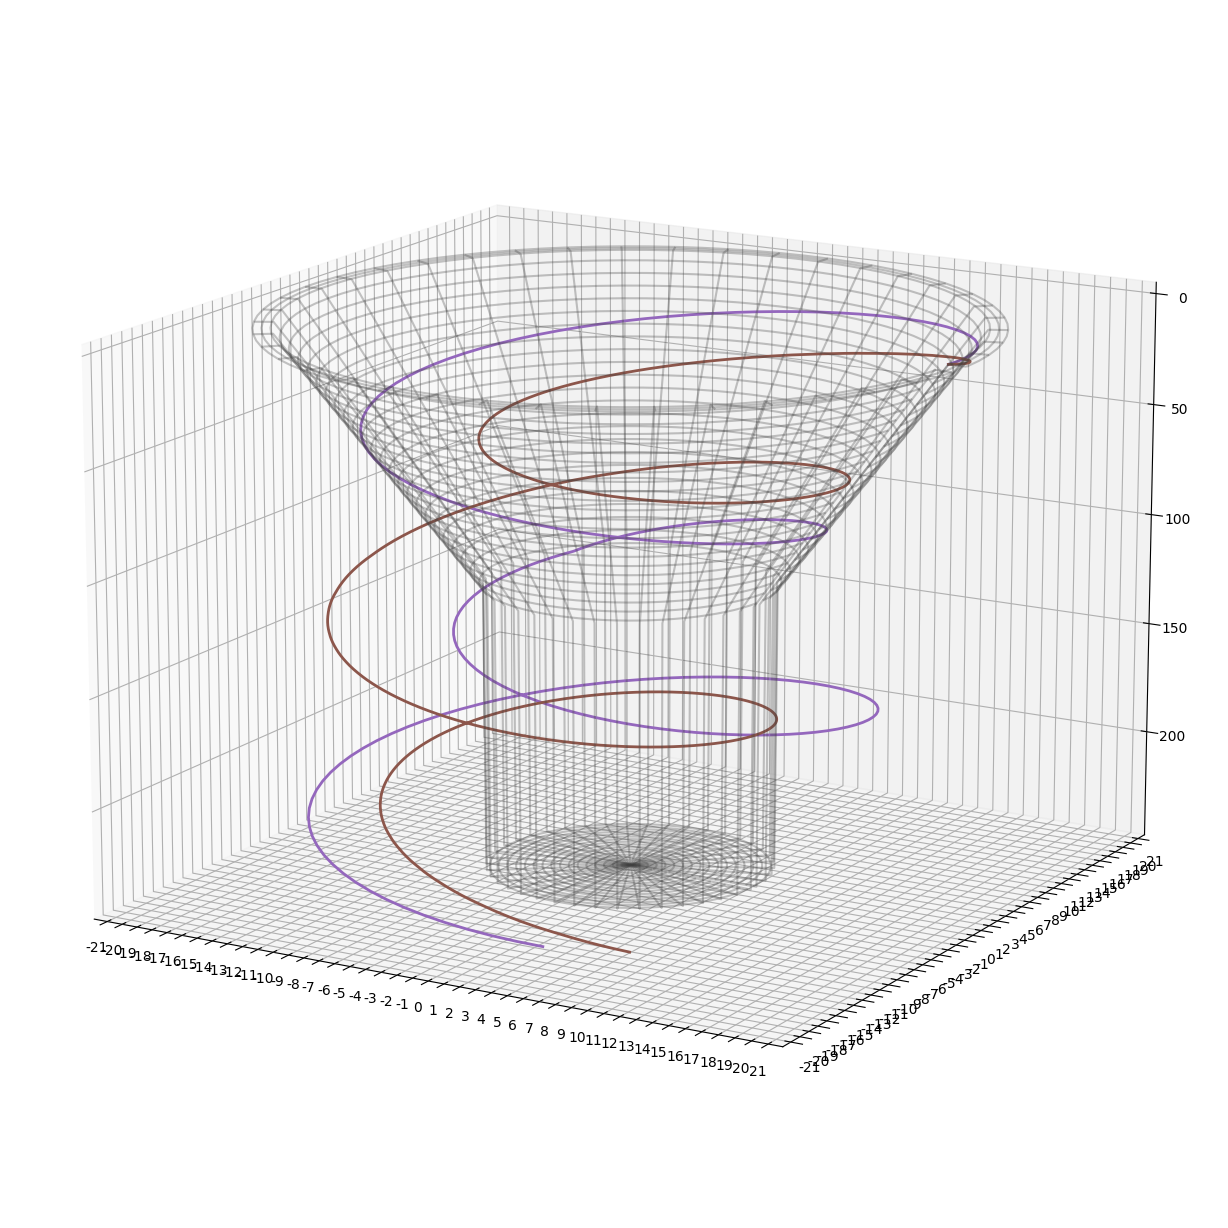

In [113]:
lattice_data = lattice.get_path_meshgrid(stone_Astar)
mesh_colors = [ ]

it = np.nditer([lattice_data[0], lattice_data[1]], flags=['multi_index'])
for x, y, in it:
    mesh_colors.append((0.25, 0.25, 0.25, 0.3))

Astar_data = stone_Astar.get_path_as_np()
total_elapsed_time = len(Astar_data[2])
verlet_data = stone_Verlet.get_path_as_np()
astar_to_verlet_ratio = total_elapsed_time/len(verlet_data[2])
verlet_data = (verlet_data[0], verlet_data[1], np.multiply(verlet_data[2], astar_to_verlet_ratio))

import matplotlib.animation as animation

do_animation = True

if do_animation:
   
    def prepare_figure(lattice, elapsed_time, figure_size = (16,16)):
        fig = plt.figure(figsize=figure_size, dpi=100,)
        ax = fig.add_subplot(projection='3d')

        ax.set_xlim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
        ax.set_xticks([x for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
        ax.set_xticklabels( [f'{int(x)}' for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

        ax.set_ylim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
        ax.set_yticks([y for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
        ax.set_yticklabels( [f'{int(y)}' for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

        ax.set_zlim( bottom=elapsed_time+10, top=0,)

        return fig, ax

    fig, ax = prepare_figure(lattice, total_elapsed_time)

    wire_frame = ax.plot_wireframe(lattice_data[0], lattice_data[1], lattice_data[2], colors=mesh_colors)

    lines = [ ]
    lines.append(ax.plot([], [], [], c='C4', linewidth=2.0)[0])
    lines.append(ax.plot([], [], [], c='C5', linewidth=2.0)[0])

    def animate_path_3D(frame_number, lines, Astar_data, verlet_data): #lines, wire_frame
        # if wire_frame:
        #     wire_frame.remove()
        # # lattice_time = np.where(lattice_data[2] <= frame_number, lattice_data[2], 0)
        # wire_frame = 
        # line[0].set_data_3d(lattice_data[0], lattice_data[1], np.where(lattice_data[2] <= frame_number, lattice_data[2], 0))

        ax.clear()

        ax.set_xlim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
        ax.set_xticks([x for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
        ax.set_xticklabels( [f'{int(x)}' for x in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

        ax.set_ylim( (-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r) )
        ax.set_yticks([y for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])
        ax.set_yticklabels( [f'{int(y)}' for y in range(-lattice.polar_dimensions.outer_r, lattice.polar_dimensions.outer_r + 1)])

        if frame_number < total_elapsed_time:
            ax.set_zlim( bottom=frame_number+1, top=0,)
        else:
            ax.set_zlim( bottom=total_elapsed_time+10, top=0,)

        lattice_time = np.where(lattice_data[2] <= frame_number, lattice_data[2], frame_number+1)
        ax.plot_wireframe(lattice_data[0], lattice_data[1], lattice_time, colors=mesh_colors)

        x_data, y_data, t_data = Astar_data
        ax.plot(x_data[:frame_number], y_data[:frame_number], t_data[:frame_number], c='C4', linewidth=2.0)

        x_data, y_data, t_data = verlet_data
        verlet_time_code = int((frame_number)/astar_to_verlet_ratio)
        ax.plot(x_data[:verlet_time_code], y_data[:verlet_time_code], t_data[:verlet_time_code], c='C5', linewidth=2.0)
        # for line, (x_data, y_data, t_data ) in zip(lines, stone_data):
        #     line.set_data_3d(x_data[:frame_number], y_data[:frame_number], t_data[:frame_number])
        return lines

    for elevation in [15, ]:
        ax.view_init(elevation, -60)

        frames = total_elapsed_time + 90

        if elevation == 30:
            frames = total_elapsed_time + 360

        anim = animation.FuncAnimation(fig, animate_path_3D, frames=frames, fargs=(lines, Astar_data, verlet_data))

        writer = animation.PillowWriter(fps=30)
        from pathlib import Path
        file = Path().absolute()

        anim.save(f'{file}\\Pathfinding\\Astar vs Verlet comparision, lattice resolution (dr={lattice_dimensions.r_resolution}, dphi={lattice_dimensions.phi_resolution}).gif', writer=writer, dpi=100)